# 1,インストール・インポート

次回

物件の面積と部屋数などの変数をいじるといいことあるかもしれない

欠損フラグ列を作ってみる
0ではなく-1の補完のほうがいいかも
次回ヒートマップで相関関係わかったのでそれを累積重要度95％のものにカラム追加する　6個追加

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# !pip install autogluon

In [3]:
# import numpy as np
# from sklearn.metrics import mean_squared_error
# from autogluon.tabular import TabularPredictor

# # 1. 目的変数を対数変換（Kaggleの鉄則）
# train['SalePrice'] = np.log1p(train['SalePrice'])

# # 2. AutoGluonの学習（10分全力）
# predictor_log = TabularPredictor(label='SalePrice').fit(
#     train_data=train, 
#     time_limit=600, 
#     num_gpus=1
# )

# # 3. 学習データのスコア（Train Score）を計算
# # 既にデータが対数化されているので、普通のRMSEを計算するだけでKaggleのRMSLEと完全に一致します
# train_predictions = predictor_log.predict(train)
# train_score = np.sqrt(mean_squared_error(train['SalePrice'], train_predictions))

# # 4. 検証データのスコア（Valid Score）をリーダーボードから取得
# val_score = abs(predictor_log.leaderboard(silent=True).iloc[0]['score_val'])

# # 5. るきあ君指定のフォーマットで出力
# print(f"Mean Train Score : {train_score:.5f}")
# print(f"Mean Valid Score : {val_score:.5f}")
# print(f"Mean GAP (過学習) : {val_score - train_score:.5f}")

In [4]:
# # 1. 予測（この時点ではまだ対数スケールの数字）
# log_predictions = predictor_log.predict(test)

# # 2. 指数関数 np.expm1 で元のドルの単位に戻す（超重要！）
# final_predictions = np.expm1(log_predictions)

# # 1. サンプルファイルを読み込んで枠組みを利用する
# submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

# # 2. 予測値を代入
# submission['SalePrice'] = final_predictions

# # 3. CSVとして保存
# submission.to_csv('submission.csv', index=False)

# print("✅ submission.csv が完成しました！")

NameError: name 'predictor_log' is not defined

In [6]:
# #ここで必要なもの全てインストール
# !pip install japanize-matplotlib  
# !pip install ydata-profiling 
# !pip install sweetviz
!pip install catboost

In [7]:
#標準装備のnumpy2.0ではsweetvizが動かないためバージョンをさげる
# !pip install --force-reinstall numpy==1.26.4 #保存時のみrun allができなくくてエラーが出るのでコメントアウトする


In [8]:
# モジュールのインポート
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import japanize_matplotlib
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
# import sweetviz as sv #sweetvizを用いるため
import lightgbm as lgb
import xgboost as xgb
from scipy import stats#サイパイでウィルコクソンの順位和検定を行うため
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレストによる分類の場合
from sklearn.ensemble import RandomForestRegressor   #ランダムフォレストの回帰の場合、つまり今回
from sklearn.model_selection import StratifiedKFold  # 層化K分割交差検証を行うクラスただし分類問題のみで使うので今回は違う
from sklearn.model_selection import KFold#KK分割交差検証で用いる
# from ydata_profiling import ProfileReport#YData-ProfilingというEDAツールを使うため
from catboost import CatBoostClassifier#catboostを使うため(分類なので今回は使わない)
from catboost import CatBoostRegressor#catboostを使うため(回帰なので今回は使わない)
from sklearn.model_selection import train_test_split#データを学習用と検証用にわける
from sklearn.linear_model import LogisticRegression#ロジスティック回帰モデルをベースラインモデルとして作るため
from sklearn.preprocessing import StandardScaler#標準化するため
from sklearn.pipeline import Pipeline#前処理とモデルをまとめて順番通りに自動でやってくれる箱
from sklearn.model_selection import cross_val_score#ロジスティック回帰モデル用のデータを分けるため
from matplotlib.ticker import MultipleLocator#一定間隔でメモリをおく
from scipy.stats import mannwhitneyu#ウィルコクソンの順位和検定のため
from sklearn.cluster import KMeans#k-means法を用いるため　これでクラスタリングを行う
from sklearn.experimental import enable_iterative_imputer#ここでIterativeImputerが「実験的機能を使います」と宣言する。これがないと次でエラーがでる
from sklearn.impute import IterativeImputer#欠損値補完でIterativeImputerを使用するため
from sklearn.metrics import mean_squared_error#評価指標である平均二乗誤差を計算するため

In [9]:
#セッション再起動してからバージョンを下げることができてるかの確認
print(np.__version__)

2.0.2


# 2,データの概要

In [71]:
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [73]:
train_original=train.copy()
test_original=test.copy()

In [12]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [14]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [15]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


## カラム名の和訳(英語では概要をつかみにくいので)

番号,カラム名,日本語訳・意味<br>
0,Id,物件ID<br>
1,MSSubClass,建物の等級（1階建て、2階建て、新築など）<br>
2,MSZoning,用途地域区分（商業、住宅など）<br>
3,LotFrontage,道路に接している長さ（フィート）<br>
4,LotArea,敷地面積（平方フィート）<br>
5,Street,道路の舗装状態（砂利、舗装）<br>
6,Alley,路地へのアクセスの種類<br>
7,LotShape,敷地の形状（規則的、不規則）<br>
8,LandContour,土地の平坦さ<br>
9,Utilities,利用可能な公共サービス（水道、電気など）<br>
10,LotConfig,敷地の区画構成（角地など）<br>
11,LandSlope,土地の傾斜<br>
12,Neighborhood,エイムス市内の地区名（立地）<br>
13,Condition1,幹線道路や鉄道への近接性<br>
14,Condition2,幹線道路や鉄道への近接性（複数ある場合）<br>
15,BldgType,建物の種類（戸建て、タウンハウスなど）<br>
16,HouseStyle,住宅のスタイル（平屋、2階建てなど）<br>
17,OverallQual,全体の素材と仕上げの品質（1-10評価）<br>
18,OverallCond,全体的な状態の評価（1-10評価）<br>
19,YearBuilt,建設年<br>
20,YearRemodAdd,改築・リフォーム年<br>
21,RoofStyle,屋根の形状<br>
22,RoofMatl,屋根の素材<br>
23,Exterior1st,外壁材1<br>
24,Exterior2nd,外壁材2<br>
25,MasVnrType,外装用石積みの種類<br>
26,MasVnrArea,外装用石積みの面積<br>
27,ExterQual,外装材の品質評価<br>
28,ExterCond,外装材の状態評価<br>
29,Foundation,基礎の種類（コンクリートなど）<br>
30,BsmtQual,地下室の高さ（品質評価）<br>
31,BsmtCond,地下室の全体的な状態<br>
32,BsmtExposure,地下室の露出具合（外光、換気）<br>
33,BsmtFinType1,地下室の仕上げ評価1<br>
34,BsmtFinSF1,地下室の仕上げ面積1<br>
35,BsmtFinType2,地下室の仕上げ評価2<br>
36,BsmtFinSF2,地下室の仕上げ面積2<br>
37,BsmtUnfSF,地下室の未仕上げ面積<br>
38,TotalBsmtSF,地下室の総面積<br>
39,Heating,暖房の種類<br>
40,HeatingQC,暖房の品質と状態<br>
41,CentralAir,セントラルエアコンの有無（Y/N）<br>
42,Electrical,電気システム<br>
43,1stFlrSF,1階の面積<br>
44,2ndFlrSF,2階の面積<br>
45,LowQualFinSF,低品質な仕上げの面積（全フロア）<br>
46,GrLivArea,地上の居住面積合計（平方フィート）<br>
47,BsmtFullBath,地下室のフルバスルーム数<br>
48,BsmtHalfBath,地下室のハーフバスルーム数<br>
49,FullBath,地上のフルバスルーム数<br>
50,HalfBath,地上のハーフバスルーム数<br>
51,BedroomAbvGr,地上のベッドルーム数<br>
52,KitchenAbvGr,地上のキッチン数<br>
53,KitchenQual,キッチンの品質評価<br>
54,TotRmsAbvGrd,地上の総部屋数（バスルーム除く）<br>
55,Functional,住宅の機能性評価<br>
56,Fireplaces,暖炉の数<br>
57,FireplaceQu,暖炉の品質<br>
58,GarageType,ガレージの種類<br>
59,GarageYrBlt,ガレージの建設年<br>
60,GarageFinish,ガレージの内装仕上げ具合<br>
61,GarageCars,ガレージの収容台数<br>
62,GarageArea,ガレージの面積<br>
63,GarageQual,ガレージの品質<br>
64,GarageCond,ガレージの状態<br>
65,PavedDrive,ドライブウェイ（私道）の舗装状態<br>
66,WoodDeckSF,ウッドデッキの面積<br>
67,OpenPorchSF,オープンポーチの面積<br>
68,EnclosedPorch,囲いのあるポーチの面積<br>
69,3SsnPorch,三季用ポーチの面積<br>
70,ScreenPorch,スクリーンポーチ（網戸付き）の面積<br>
71,PoolArea,プールの面積<br>
72,PoolQC,プールの品質<br>
73,Fence,柵の品質<br>
74,MiscFeature,その他（テニスコート、納屋など）<br>
75,MiscVal,その他特徴の価値<br>
76,MoSold,売却月<br>
77,YrSold,売却年<br>
78,SaleType,販売の種類<br>
79,SaleCondition,販売条件<br>
80,SalePrice,販売価格（予測するターゲット）<br>

# 3,EDA

In [18]:
#先にtrainとtestで片方にしかないカラムがあるとだめなので探索する
# Trainにしか存在しない列（SalePriceなどがここに入るはず）
train_only = set(train.columns) - set(test.columns)
print(f"Trainにしかない列: {train_only}")

# Testにしか存在しない列（もしあれば、削除対象）
test_only = set(test.columns) - set(train.columns)
print(f"Testにしかない列: {test_only}")

Trainにしかない列: {'SalePrice'}
Testにしかない列: set()


## (1)trainに関するEDA

In [19]:
#insull().sum()に追加で.to_stiringメソッドを追加することにより全行表示が可能(今回はしない)
#pandasではデータフレーム[True/Falseのリスト] と書くと、Trueの行だけを抽出するというルールがある
#[]により先に比較演算が行われる
train_null_df=train.isnull()
train_null=train.isnull().sum()
train_null=train_null[train_null>0]
print(train_null)

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [20]:
#df名[df名　比較演算子　数]　→これによりdfの中でも条件を満たした行のみが取り出される
test_null=test.isnull().sum()
test_null=test_null[test_null>0]
print(test_null)


MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType       894
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


In [21]:
#pd.concat([,])で二つのdfの接合が可能  axis=1は横方向に接続という意味
#.columnsメソッドでカラム名を指定
#.filina(0)で欠損値を0にする
#>0で0より大きいならTrue、0より小さにならFalse(bool型にしてる)
#.astype(int)メソッドによりTrueが1、falseが0になる(boola型をint型へ)
df_null=pd.concat([train_null,test_null],axis=1)
df_null.columns=['train_null','test_null']
df_null=(df_null.fillna(0)>-0).astype(int)

print(df_null)

              train_null  test_null
LotFrontage            1          1
Alley                  1          1
MasVnrType             1          1
MasVnrArea             1          1
BsmtQual               1          1
BsmtCond               1          1
BsmtExposure           1          1
BsmtFinType1           1          1
BsmtFinType2           1          1
Electrical             1          0
FireplaceQu            1          1
GarageType             1          1
GarageYrBlt            1          1
GarageFinish           1          1
GarageQual             1          1
GarageCond             1          1
PoolQC                 1          1
Fence                  1          1
MiscFeature            1          1
MSZoning               0          1
Utilities              0          1
Exterior1st            0          1
Exterior2nd            0          1
BsmtFinSF1             0          1
BsmtFinSF2             0          1
BsmtUnfSF              0          1
TotalBsmtSF            0    

In [22]:
# #YData-Profilingの実行
# from ydata_profiling import ProfileReport
# profile = ProfileReport(train, title="ydata-profilingによるEDA結果", explorative=True)

# # 4. レポートをノートブック上に表示
# profile.to_notebook_iframe()

# # # 5. HTMLとして保存
# # profile.to_file("ydata_analysis.html")

In [23]:
# #保存時はnumpyのバージョンを下げることが出ずにエラーがでるのでコメントアウト
# sweetviz_report = sv.analyze(train, target_feat='SalePrice')

# #ここでnotebook上の表示
# sweetviz_report.show_notebook()

# # # レポートをHTMLで出力して表示
# # sweetviz_report.show_html("Sweetviz_Report.html")

## (2)testに関するEDA

In [24]:
# #YData-Profilingの実行
# from ydata_profiling import ProfileReport
# profile = ProfileReport(test, title="ydata-profilingによるEDA結果", explorative=True)



# #  HTMLとして保存
# profile.to_file("ydata_analysis_test.html")

In [25]:
# #保存時はnumpyのバージョンを下げることが出ずにエラーがでるのでコメントアウト
# #今回は目的変数なし
# sweetviz_report = sv.analyze(test)

# # レポートをHTMLで出力して表示
# sweetviz_report.show_html("Sweetviz_Report_test.html")

# 4,前処理

In [26]:
#.dropメソッドで()にカラム名とaxisで行か列を指定すると消える
train=train.drop('Id',axis=1)
test=test.drop('Id',axis=1)

## (1)trainの欠損値処理

trainの欠損値の一覧<br>
・LotFrontage has 259 (17.7%) missing valuesなので少ない<r>
・LotFrontage has 259 (17.7%) missing valuesなので少ない<br>
・Alley has 1369 (93.8%) missing valuesなのでこれは明らか欠損多い<br>
・MasVnrType has 872 (59.7%) missing valuesなので少し多い<br>
・BsmtQual has 37 (2.5%) missing valuesなので少ない<br>
・BsmtCond has 37 (2.5%) missing valuesなので少ない<br>
・BsmtExposure has 38 (2.6%) missing valuesなので少ない<br>	
・BsmtFinType1 has 37 (2.5%) missing valuesなので少ない<br>
・BsmtFinType2 has 38 (2.6%) missing valuesなので少ない<br>
・FireplaceQu has 690 (47.3%) missing valuesなので少し多い<br>
・GarageType has 81 (5.5%) missing valuesなので少ない<br>
・GarageYrBlt has 81 (5.5%) missing valuesなので少ない	<br>
・GarageFinish has 81 (5.5%) missing valuesなので少ない	<br>
・GarageQual has 81 (5.5%) missing valuesなので少ない<br>
・GarageCond has 81 (5.5%) missing valuesなので少ない<br>
・PoolQC has 1453 (99.5%) missing values多い	<br>
・Fence has 1179 (80.8%) missing values	多い<br>
・MiscFeature has 1406 (96.3%) missing 多いの<br>

In [27]:
# #はじめ欠損が多いもののみが意図的に欠損させたものと思ってた時のコード
# # 調べたいカラムのリスト
# target_cols = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

# for col in target_cols:
#     print(f"{col} の中身")
#     # .value_countsメソッドで種類を数えることが可能  dropna=Falseで欠損値込みで数える
#     print(train[col].value_counts(dropna=False))
#     print('\n')#\nで改行が可能
    

### ①trainの欠損値処理の確定
欠損値の割合が大きいものはその欠損自体に意味があると仮定しあえて欠損値処理を行わない　<br>
「うっかり忘れ」か「あえて（無し）」かの区別がつかないのが、IterativeImputerの弱点であり、うっかり忘れたときに強い。<br>
ただし仮にそのnanが0という意味だったらIterativeImputerでは0という予測はできない<br><br>


ここで欠損値が多いと指定したものは意図的であるものが高いと思い仕様書を用いて調べてみたが本当に欠損しているものはLotFrontageだけだった<br>

---欠損値処理の方法---<br>
①LotFrontageにはIterativeImputerで欠損値処理<br>
②その他のint,float型データは0を代入して欠損値処理<br>
③その他のカテゴリデータはNoneをだいにゅうすて欠損値処理<br>

### ②trainの欠損値処理の実行

In [74]:
#まず欠損してる列の型をわける
# 1. チェックしたいカラムのリスト
target_cols = [
    'LotFrontage', 'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
    'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence', 'MiscFeature','MasVnrArea','Electrical'
]

# 2. 数値型と文字型に分ける
numeric_cols = train[target_cols].select_dtypes(include=['number']).columns.tolist()
object_cols = train[target_cols].select_dtypes(include=['object']).columns.tolist()

# 3. 結果を表示
print("数値型（0や予測値を入れる）")
print(numeric_cols)
print("\n文字型（'None'を入れる）")
print(object_cols)

数値型（0や予測値を入れる）
['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

文字型（'None'を入れる）
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Electrical']


In [75]:
#1,LotFrontageをIterativeImputerで欠損値補完
#この際ヒントをとってくるためLotFrontageと相関が高いカラムをsweetvizから取ってくる
# 1. Sweetvizで確認した相関の高い4項目 + 埋めたい項目をリスト化 
target_and_hints = ['LotFrontage', 'LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']

# 2. IterativeImputerの設定　ここで学習
it_imp = IterativeImputer(max_iter=10, random_state=42)

# 3. 補完の実行 ここで実行
# 指定した5つの列のデータセットを渡し、LotFrontageの欠損を予測して上書きします
train[target_and_hints] = it_imp.fit_transform(train[target_and_hints])

# 4. 確認
print(f"LotFrontageの欠損数: {train['LotFrontage'].isnull().sum()}")

LotFrontageの欠損数: 0


In [77]:
train['GarageYrBlt'].value_counts()

GarageYrBlt
-1.0       81
 2005.0    65
 2006.0    59
 2004.0    53
 2003.0    50
 2007.0    49
 1977.0    35
 1998.0    31
 1999.0    30
 1976.0    29
 2008.0    29
 2000.0    27
 2002.0    26
 1968.0    26
 1950.0    24
 1993.0    22
 1966.0    21
 1958.0    21
 1962.0    21
 2009.0    21
 1965.0    21
 1957.0    20
 1996.0    20
 1970.0    20
 2001.0    20
 1954.0    19
 1960.0    19
 1978.0    19
 1997.0    19
 1974.0    18
 1964.0    18
 1995.0    18
 1994.0    18
 1959.0    17
 1990.0    16
 1963.0    16
 1956.0    16
 1967.0    15
 1980.0    15
 1979.0    15
 1969.0    15
 1920.0    14
 1940.0    14
 1972.0    14
 1973.0    14
 1988.0    14
 1971.0    13
 1961.0    13
 1955.0    13
 1992.0    13
 1953.0    12
 1987.0    11
 1948.0    11
 1925.0    10
 1941.0    10
 1985.0    10
 1981.0    10
 1989.0    10
 1939.0     9
 1975.0     9
 1991.0     9
 1930.0     8
 1949.0     8
 1984.0     8
 1983.0     7
 1926.0     6
 1951.0     6
 1986.0     6
 1936.0     5
 1916.0     5
 1922.0 

In [76]:
#2数値の型であるGarageYrBltとMasVnrAreaを0で補完する
#fillna()メソッドは指定した値で欠損値を埋めるという意味
tran=['GarageYrBlt','MasVnrArea']
train[tran]=train[tran].fillna(-1)

#isnullで欠損があるかないかの0(False)と1(True)混合のdfを作ってsumでその欠損数を数える
print(f"欠損数: {train[tran].isnull().sum()}")

欠損数: GarageYrBlt    0
MasVnrArea     0
dtype: int64


In [78]:
#3文字型の欠損をNoneで代入
#先にlistでカラムをまとめたほうがpandasの処理が早くなる
trans=['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
       'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature','Electrical']

train[trans]=train[trans].fillna('None')
print(f"カテゴリデータの欠損数: {train[trans].isnull().sum()}")

カテゴリデータの欠損数: Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
Electrical      0
dtype: int64


In [64]:
# 表示する行数の上限を解除（None = 無制限）
pd.set_option('display.max_rows', None)

train.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

## (2)trainのエンコーディング

### エンコーディングの方針
・targetencodingとはその要素と目的変数の関係を見てencodingする手法でただしこの際encodingしたい列を除外する。targetencodingは強力な手法だが上手にやらないとリークする可能性がある。<br>
・とりあえずベースモデル構築まではonehot、feature hashing、label、count、frequency、labelcount、Ordinal Encodingの中から選ぶ。<br>
・決定木モデルをメインに使う予定なので不均衡データでも種類数がすくないとonehotを採用する<br>

In [79]:
#.columns.tolist()をすることでdfだったのをカラム名だけにしたlistを取得することができる
category = train.select_dtypes(include=['object']).columns.tolist()

#.nunique()で種類数、value_counts()で実際の種類
for col in category:
    print(f"--- {col} ---")
    print(f"種類数: {train[col].nunique()}") # 何種類の値があるか  nuniqueでカラムの中身の種類数がわかる
    print(train[col].value_counts()) # value_countsメソッドで実際の種類が分かる
    print("\n")

--- MSZoning ---
種類数: 5
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64


--- Street ---
種類数: 2
Street
Pave    1454
Grvl       6
Name: count, dtype: int64


--- Alley ---
種類数: 3
Alley
None    1369
Grvl      50
Pave      41
Name: count, dtype: int64


--- LotShape ---
種類数: 4
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64


--- LandContour ---
種類数: 4
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64


--- Utilities ---
種類数: 2
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64


--- LotConfig ---
種類数: 5
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64


--- LandSlope ---
種類数: 3
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64


--- Neighborhood ---
種類数: 25
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert   

完全に優越のある、順位のある以下のカラムはordinalencoding
categoryというカテゴリデータのlistの中から

BsmtCond

HeatingQC

KitchenQual

FireplaceQu

GarageQual

GarageCond

PoolQC

をordinalencoding

In [80]:
# 1. Ordinal Encoding（順序あり）にするカラムのリスト定義
# 標準的な品質評価 (Ex, Gd, TA...) のグループ
ordinal_qual_cols = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'HeatingQC', 'KitchenQual', 'FireplaceQu', 
    'GarageQual', 'GarageCond', 'PoolQC','BsmtExposure'
]
# 形状 (Reg, IR1...) のグループ
ordinal_shape_cols = ['LotShape']

# すべてのOrdinal系カラムをまとめたリスト（後で除外するため） これを省いたものをonehot
all_ordinal_cols = ordinal_qual_cols + ordinal_shape_cols


# 2. マッピング辞書（変換ルール）の作成 辞書型
# 品質用: Ex(5) > Gd(4) > TA(3) > Fa(2) > Po(1) > None(0)
qual_map = {
    'Ex': 5, 'Gd': 4, 'Av': 3, 'TA': 3, 'Fa': 2, 'Mn': 2, 'Po': 1,'No': 1, 
    'None': 0, 'NA': 0
}

# 形状用: Reg(3) > IR1(2) > IR2(1) > IR3(0)
shape_map = {
    'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0
}


# 3. Ordinal Encoding の実行
# 注意: マップする前に欠損値(NaN)を 'None' という文字列に埋めます
# これにより、「地下室なし」や「ガレージなし」が数値の 0 に変換されます

# 品質系の変換 map関数はあり規則に基づいて一気に置き換える手法
for col in ordinal_qual_cols:
    train[col] = train[col].fillna('None').map(qual_map)

# 形状系の変換
for col in ordinal_shape_cols:
    train[col] = train[col].fillna('None').map(shape_map)


# 4. 残りのカテゴリ変数を One-Hot Encoding
# 元の `category` リストから、今変換した Ordinal カラムを除外する 内包表記(結果代入用変数、ループ、条件)
remaining_cat_cols = [c for c in category if c not in all_ordinal_cols]

# 残りだけを One-Hot Encoding
#get_dummiesでonehotencoding実行
train_encoding = pd.get_dummies(train, columns=remaining_cat_cols, drop_first=False)

# 確認
print("--- 処理完了 ---")
print(f"Ordinal変換したカラム数: {len(all_ordinal_cols)}")
print(f"One-Hot変換したカラム数: {len(remaining_cat_cols)}")
print(f"現在の全カラム数: {train_encoding.shape[1]}")

# ちゃんと数値になっているかチラ見
train＿encoding[ordinal_qual_cols + ordinal_shape_cols].head()

--- 処理完了 ---
Ordinal変換したカラム数: 12
One-Hot変換したカラム数: 31
現在の全カラム数: 258


,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,BsmtExposure,LotShape
0,4,3,4,3,5,4,0,3,3,0,1,3
1,3,3,4,3,5,3,3,3,3,0,4,3
2,4,3,4,3,5,4,3,3,3,0,2,2
3,3,3,3,4,4,4,4,3,3,0,1,2
4,4,3,4,3,5,4,3,3,3,0,3,2


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

## (3)testの欠損値処理

欠損値補完: Trainで使った it_imp (IterativeImputer) を使って、Testデータを補完してください（fitはせずtransformのみ）。

One-Hot Encodingの罠: pd.get_dummies をTrainとTest別々に実行すると、**「TrainにはあるがTestにはないカテゴリ」**があった場合、カラム数（列の数）が合わなくなり、モデルに入れた瞬間にエラーになります。

解決策: TrainとTestを一度結合してから get_dummies するか、One-Hot Encoderなどのライブラリを使うのが安全ですが、まずは簡単な方法として、処理後に align を使う方法などを調べると良いでしょう。

In [81]:
# 1. 欠損値があるカラム名だけをリスト形式で取得
#.columnsでカラム名だけ抽出、.any()で1個でもTrueだったら持ってくる、.tolistでリスト型に変換
test_missing_cols = test.columns[test.isnull().any()].tolist()

# 2. ついでに「いくつ欠損しているか」も確認（これが見やすいです）
test_missing_info = test[test_missing_cols].isnull().sum()

print("--- 欠損があるカラムのリスト ---")
print(test_missing_cols)
print("\n--- 欠損数 ---")
print(test_missing_info)

--- 欠損があるカラムのリスト ---
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']

--- 欠損数 ---
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType       894
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
Gar

### <概要>補完方法<br>

他の値がほぼ同じ値→最頻値<br>
特に関係がない&外れ値がある→中央値<br>
特に関係がない&きれいな分布→平均値<br>
他の物と関係が深くある→IterativeImputer<br>

### ①意図的でないものの欠損補完

仕様書を見て以下のカラムが意図的な欠損でないと判断した。
また、EDAを行いデータの分布などを見て補完方法を決めていく(sweetvizより判断)

MSZoning: 用途地域（最頻値RLで埋める）

LotFrontage: 道路に接する間口（Trainと同様にIterativeImputer）

Utilities: インフラ設備（最頻値AllPubで埋める）

Exterior1st: 外壁材1（IterativeImputer,Exterior2ndとYearRemodAddとGarageAreaを使う）

Exterior2nd: 外壁材2（IterativeImputer、Exterior1stとYearBuiltとYearRemodAddを使う）

KitchenQual: キッチンの品質（最頻値1で埋める）

Functional: 機能性（最頻値Typで埋める）

SaleType: 販売タイプ（最頻値WLで埋める）

In [82]:
#欠損方法は自分で考えたが以下のコードはgeminiのものをコピペした
#ポイントはカテゴリデータのままではIterativeImputerは動かないのでenumrate関数で数を与える(ラベルエンコーディングと似てる)
# ==========================================
# 1. 最頻値（固定値）でサクッと埋めるグループ
# ==========================================
test['MSZoning'] = test['MSZoning'].fillna('RL')
test['Utilities'] = test['Utilities'].fillna('AllPub')
test['Functional'] = test['Functional'].fillna('Typ')

# ※補足の通り、KitchenQualは'TA'、SaleTypeは'WD'に修正してあります
test['KitchenQual'] = test['KitchenQual'].fillna('TA')
test['SaleType'] = test['SaleType'].fillna('WD')

# ==========================================
# 2. LotFrontage の予測補完（Trainと同じ手法）
# ==========================================
it_imp_lot = IterativeImputer(max_iter=10, random_state=42)
# Trainの時と同じヒント変数（面積系）を使用
lot_features = ['LotFrontage', 'LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
test[lot_features] = it_imp_lot.fit_transform(test[lot_features])

# ==========================================
# 3. Exterior1st と Exterior2nd の予測補完
# ==========================================
# ※文字データはそのままIterativeImputerに入れられないため、一時的に数字に変換して予測し、元に戻します

# ① 文字を数字に変換する辞書を作成
#dropnaで欠損値を含む行や列をまるごと削除
ext1_unique = test['Exterior1st'].dropna().unique()
ext2_unique = test['Exterior2nd'].dropna().unique()

ext1_map = {val: i for i, val in enumerate(ext1_unique)}
ext2_map = {val: i for i, val in enumerate(ext2_unique)}

# ② 数字を文字に戻すための逆引き辞書を作成
#enumerate関数は文字列に数を与える
ext1_inv_map = {i: val for i, val in enumerate(ext1_unique)}
ext2_inv_map = {i: val for i, val in enumerate(ext2_unique)}

# ③ 一時的に数字に変換したカラムを作成（NaNはNaNのまま）
#mapは変換したいときに辞書を参照して変換する関数
test['Ext1_num'] = test['Exterior1st'].map(ext1_map)
test['Ext2_num'] = test['Exterior2nd'].map(ext2_map)

# ④ IterativeImputer で予測
it_imp_ext = IterativeImputer(max_iter=10, random_state=42)

# Exterior1st の補完（ご指定のヒントを使用）
ext1_cols = ['Ext1_num', 'Ext2_num', 'YearRemodAdd', 'GarageArea']
test[ext1_cols] = it_imp_ext.fit_transform(test[ext1_cols])

# Exterior2nd の補完（ご指定のヒントを使用）
ext2_cols = ['Ext2_num', 'Ext1_num', 'YearBuilt', 'YearRemodAdd']
test[ext2_cols] = it_imp_ext.fit_transform(test[ext2_cols])

# ⑤ 予測された数値を四捨五入して、元の文字データに戻して穴埋め
test['Exterior1st'] = test['Exterior1st'].fillna(test['Ext1_num'].round().map(ext1_inv_map))
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Ext2_num'].round().map(ext2_inv_map))

# ⑥ 計算用に使った一時的な数値カラムをお掃除（削除）
test.drop(['Ext1_num', 'Ext2_num'], axis=1, inplace=True)

print("テストデータの意図的ではない欠損の補完がすべて完了しました！")

テストデータの意図的ではない欠損の補完がすべて完了しました！


### ②意図的であるものの欠損補完

In [83]:
#意図的でない欠損の補完の実行
#まず欠損してる列の型をわける
# 1. チェックしたいカラムのリスト
target_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType',
    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
    'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea'
]



# 2. 数値型と文字型に分ける
numeric_col = test[target_cols].select_dtypes(include=['number']).columns.tolist()
object_col = test[target_cols].select_dtypes(include=['object']).columns.tolist()

# 3. 結果を表示
print("数値型（0や予測値を入れる）")
print(numeric_col)
print("\n文字型（'None'を入れる）")
print(object_col)

数値型（0や予測値を入れる）
['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']

文字型（'None'を入れる）
['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']


In [84]:
#数値のデータの補完

test[numeric_col]=test[numeric_col].fillna(-1)

#isnullで欠損があるかないかの0(False)と1(True)混合のdfを作ってsumでその欠損数を数える
print(f"欠損数: {test[numeric_col].isnull().sum()}")

欠損数: MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64


In [85]:
#カテゴリデータ」の補完
test[object_col]=test[object_col].fillna('None')
print(f"カテゴリデータの欠損数: {test[object_col].isnull().sum()}")

カテゴリデータの欠損数: Alley           0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
MasVnrType      0
dtype: int64


In [41]:
train.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

## (4)testのエンコーディング

In [86]:
#.columns.tolist()をすることでdfだったのをカラム名だけにしたlistを取得することができる
categor = test.select_dtypes(include=['object']).columns.tolist()
#.nunique()で種類数、value_counts()で実際の種類
for col in categor:
    print(f"--- {col} ---")
    print(f"種類数: {test[col].nunique()}") # 何種類の値があるか  nuniqueでカラムの中身の種類数がわかる
    print(test[col].value_counts()) # value_countsメソッドで実際の種類が分かる
    print("\n")

--- MSZoning ---
種類数: 5
MSZoning
RL         1118
RM          242
FV           74
C (all)      15
RH           10
Name: count, dtype: int64


--- Street ---
種類数: 2
Street
Pave    1453
Grvl       6
Name: count, dtype: int64


--- Alley ---
種類数: 3
Alley
None    1352
Grvl      70
Pave      37
Name: count, dtype: int64


--- LotShape ---
種類数: 4
LotShape
Reg    934
IR1    484
IR2     35
IR3      6
Name: count, dtype: int64


--- LandContour ---
種類数: 4
LandContour
Lvl    1311
HLS      70
Bnk      54
Low      24
Name: count, dtype: int64


--- Utilities ---
種類数: 1
Utilities
AllPub    1459
Name: count, dtype: int64


--- LotConfig ---
種類数: 5
LotConfig
Inside     1081
Corner      248
CulDSac      82
FR2          38
FR3          10
Name: count, dtype: int64


--- LandSlope ---
種類数: 3
LandSlope
Gtl    1396
Mod      60
Sev       3
Name: count, dtype: int64


--- Neighborhood ---
種類数: 25
Neighborhood
NAmes      218
OldTown    126
CollgCr    117
Somerst     96
Edwards     94
NridgHt     89
Gilbert   

In [43]:
train_encoding['Utilities_AllPub'].value_counts()

Utilities_AllPub
True     1459
False       1
Name: count, dtype: int64

In [44]:
train_encoding['Utilities_NoSeWa'].value_counts()


Utilities_NoSeWa
False    1459
True        1
Name: count, dtype: int64

### testのエンコーディングにかんする方針
1,testではUtilitiesは1種類とわかったので消す。またtrainでも片方が1種類しかないと分かったのでこのカラムは消す<br>

2,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,LotShapeには優越があるとわかったのでこれはordinal encodingを採用する<br>

3,その他はonehotencoding

In [87]:
#1,Utilitiesの削除
train_drop=['Utilities_AllPub','Utilities_NoSeWa']
train_encoding.drop(columns=train_drop)
test.drop(columns='Utilities')
print('完了')

完了


In [89]:
#2,ordinal encoding
# 1. Ordinal Encoding（順序あり）にするカラムのリスト定義
# 標準的な品質評価 (Ex, Gd, TA...) のグループ
ordinal_qual_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
                     'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC'
                     ]
# 形状 (Reg, IR1...) のグループ
ordinal_shape_cols = ['LotShape']

# すべてのOrdinal系カラムをまとめたリスト（後で除外するため） これを省いたものをonehot
all_ordinal_cols = ordinal_qual_cols + ordinal_shape_cols


# 2. マッピング辞書（変換ルール）の作成 辞書型
# 品質用: Ex(5) > Gd(4) > TA(3) > Fa(2) > Po(1) > None(0)
qual_map = {
    'Ex': 5, 'Gd': 4, 'Av': 3, 'TA': 3, 'Fa': 2, 'Mn': 2, 'Po': 1,'No': 1, 
    'None': 0, 'NA': 0
}

# 形状用: Reg(3) > IR1(2) > IR2(1) > IR3(0)
shape_map = {
    'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0
}


# 3. Ordinal Encoding の実行
# 注意: マップする前に欠損値(NaN)を 'None' という文字列に埋めます
# これにより、「地下室なし」や「ガレージなし」が数値の 0 に変換されます

# 品質系の変換 map関数はあり規則に基づいて一気に置き換える手法
for col in ordinal_qual_cols:
    test[col] = test[col].fillna('None').map(qual_map)

# 形状系の変換
for col in ordinal_shape_cols:
    test[col] = test[col].fillna('None').map(shape_map)


# 4. その他のOne-Hot Encoding
# 元の `category` リストから、今変換した Ordinal カラムを除外する 内包表記(結果代入用変数、ループ、条件)
remaining_cat_cols = [c for c in category if c not in all_ordinal_cols]

# 残りだけを One-Hot Encoding
#get_dummiesでonehotencoding実行
test_encoding = pd.get_dummies(test, columns=remaining_cat_cols, drop_first=False)

# 確認
print("--- 処理完了 ---")
print(f"Ordinal変換したカラム数: {len(all_ordinal_cols)}")
print(f"One-Hot変換したカラム数: {len(remaining_cat_cols)}")
print(f"現在の全カラム数: {test_encoding.shape[1]}")

# ちゃんと数値になっているかチラ見
test_encoding[ordinal_qual_cols + ordinal_shape_cols].head()

--- 処理完了 ---
Ordinal変換したカラム数: 12
One-Hot変換したカラム数: 31
現在の全カラム数: 240


,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,LotShape
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <重要><br>train_encodingとtest_encodingでもし片方にしか存在しない列があるとエラーがでるのでtrainにしかない場合は0にしてtestにしかない場合は削除する。また、これは片方に固有の種類が存在したときにonehotencodingすることでその分の列を作り出すことで起きる

In [90]:
# 1. 学習に使った特徴量のリストを取得（SalePriceを除外）
features = [c for c in train_encoding.columns if c != 'SalePrice' ]

# 2. Testデータの列を、Trainの列構成に強制的に合わせる
# Trainにしかない列は「0」で埋められ、Testにしかない余計な列は削除されます
test_encoding = test_encoding.reindex(columns=features, fill_value=0)

print(set(train_encoding.columns) - set(test_encoding.columns))

{'SalePrice'}


In [48]:
trainfriir.info()

NameError: name 'trainfriir' is not defined

# 7,特徴エンジニアリング
6のベースモデル提出後に行った作業なので7である。<br>
Run allでエラーが出ないようにするためにこの位置である

## (1)時系列データ

In [ ]:
years=['YrSold','MoSold','YearRemodAdd','YearBuilt']
for i in years:
    year=train[i].value_counts()
    print(year)
    

### 売却年に注目した
春夏秋冬で分ける

In [ ]:
# train_encoding1=train_encoding.copy()
# test_encoding1=train_encoding.copy()

In [ ]:
# #所属演算子を用いた書き方if A in [] :retuen B
# def make_season(month):
#     if month in [3, 4, 5]: return 'Spring'
#     if month in [6, 7, 8]: return 'Summer'
#     if month in [9, 10, 11]: return 'Autumn'
#     return 'Winter'

# # 季節カラムの追加
# #.applyでMoSoldの中身をmake_season関数の中に入れて振り分けていく
# train_encoding1['Season'] = train_encoding['MoSold'].apply(make_season)
# test_encoding1['Season'] = test_encoding['MoSold'].apply(make_season)



### <結果>むしろ下がったので消す

### (2)変数の組み合わせで新たに特徴量を生成する

# 5,モデル作成

### 方針

今回の評価指標は値段を求めるということでRMSLE（Root Mean Squared Logarithmic Error：対数平均二乗誤差偏差）を用いる。<br>
これは1000万円のものを100万円まちがえたのと200万円のものを100万円まちがえたものを同じまちがいと判断し、元の数の大きさに判断されない<be>

In [57]:
# 学習前に SalePrice を対数に変換
#外れ値の影響をマイルドにするため  豪邸とかあったらそれに影響されすぎてします恐れ
y_train_log = np.log1p(train_encoding['SalePrice'])

In [55]:
train_encoding.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 257 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    MSSubClass             1460 non-null   int64  
 1    LotFrontage            1460 non-null   float64
 2    LotArea                1460 non-null   float64
 3    LotShape               1460 non-null   int64  
 4    OverallQual            1460 non-null   int64  
 5    OverallCond            1460 non-null   int64  
 6    YearBuilt              1460 non-null   int64  
 7    YearRemodAdd           1460 non-null   int64  
 8    MasVnrArea             1460 non-null   float64
 9    ExterQual              1460 non-null   int64  
 10   ExterCond              1460 non-null   int64  
 11   BsmtQual               1460 non-null   int64  
 12   BsmtCond               1460 non-null   int64  
 13   BsmtExposure           1460 non-null   int64  
 14   BsmtFinSF1             1460 non-null  

=== 7分割 交差検証を開始 ===
Fold 1 | Train: 0.10460 | Valid: 0.16202 | GAP: 0.05742
Fold 2 | Train: 0.10641 | Valid: 0.12815 | GAP: 0.02174
Fold 3 | Train: 0.10364 | Valid: 0.15057 | GAP: 0.04693
Fold 4 | Train: 0.10245 | Valid: 0.20139 | GAP: 0.09893
Fold 5 | Train: 0.10407 | Valid: 0.16835 | GAP: 0.06428
Fold 6 | Train: 0.10558 | Valid: 0.14058 | GAP: 0.03500
Fold 7 | Train: 0.10595 | Valid: 0.13029 | GAP: 0.02434

=== モデルの総合評価（KFold平均） ===
Mean Train Score : 0.10467
Mean Valid Score : 0.15448
Mean GAP (過学習) : 0.04981



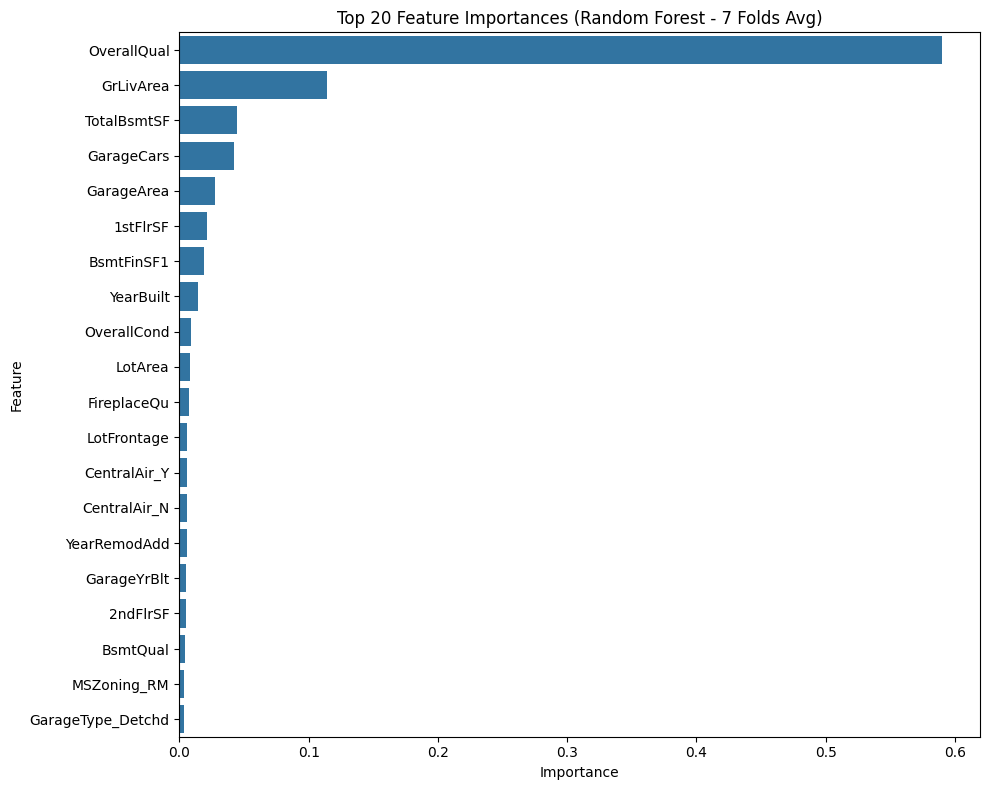

In [52]:
# 1. 特徴量(X)と目的変数(y)の準備
drop_cols = ['SalePrice']

X = train_encoding.drop(columns=drop_cols)
y = y_train_log  # 対数変換済みのターゲット

# train_test_split から KFold へ ---
n_splits = 7
# shuffle=True でデータをランダムにシャッフルしてから分割します
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 各Foldのスコアと特徴量重要度を保存するための空リスト・配列
train_scores = []
valid_scores = []
feature_importances = np.zeros(X.shape[1])

print(f"=== {n_splits}分割 交差検証を開始 ===")

# ループで分割・学習・評価を繰り返す
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    # データの分割 (ilocを使って行番号で抽出)
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # モデルの構築と学習
    rf = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
    rf.fit(X_train, y_train)
    
    # 予測
    pred_train = rf.predict(X_train)
    pred_val = rf.predict(X_val)
    
    # 評価 (RMSE = RMSLE)
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
    
    # スコアの保存
    train_scores.append(rmse_train)
    valid_scores.append(rmse_val)
    
    # 特徴量重要度の加算（最後に分割数で割って平均をとるため）
    feature_importances += rf.feature_importances_ / n_splits
    
    # 各Foldの結果を表示
    print(f"Fold {fold+1} | Train: {rmse_train:.5f} | Valid: {rmse_val:.5f} | GAP: {rmse_val - rmse_train:.5f}")

# 全体の平均スコアを計算
mean_train_score = np.mean(train_scores)
mean_valid_score = np.mean(valid_scores)

print("\n=== モデルの総合評価（KFold平均） ===")
print(f"Mean Train Score : {mean_train_score:.5f}")
print(f"Mean Valid Score : {mean_valid_score:.5f}")
print(f"Mean GAP (過学習) : {mean_valid_score - mean_train_score:.5f}")
print("==================================\n")

# 5. Feature Importance（特徴量重要度）の表示
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 上位20個をグラフ化
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title(f'Top 20 Feature Importances (Random Forest - {n_splits} Folds Avg)')
plt.tight_layout()
plt.show()

In [ ]:
# 1. 特徴量(X)と目的変数(y)の準備
drop_cols = ['SalePrice']

X = train_encoding.drop(columns=drop_cols)
y = y_train_log  # 対数変換済みのターゲット

# 7分割のKFold設定
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

train_scores = []
valid_scores = []
feature_importances = np.zeros(X.shape[1])

print(f"=== LightGBM {n_splits}分割 交差検証を開始 ===")

# ループで分割・学習・評価を繰り返す
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    # データの分割
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    # モデルの構築と学習 (LightGBMRegressorを使用)
    # learning_rate: 学習の歩幅（0.05〜0.1あたりが標準的です）
    lgbm = lgb.LGBMRegressor(
        n_estimators=200, 
        max_depth=5, 
        learning_rate=0.02, 
        random_state=42,
        importance_type='gain', # spilitでは頻度が重要視されるがgainは損失の減少量が注目される
        verbosity=-1 #致命的なエラー以外はださない
    )
    
    # LightGBMは学習時に検証用データを渡すことで、より詳細な挙動を確認できますが、
    # 今回はランダムフォレストと全く同じ条件で fit させます。
    lgbm.fit(X_train, y_train)
    
    # 予測
    pred_train = lgbm.predict(X_train)
    pred_val = lgbm.predict(X_val)
    
    # 評価 (RMSE = RMSLE)
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
    
    # スコアの保存
    train_scores.append(rmse_train)
    valid_scores.append(rmse_val)
    
    # 特徴量重要度の加算
    feature_importances += lgbm.feature_importances_ / n_splits
    
    print(f"Fold {fold+1} | Train: {rmse_train:.5f} | Valid: {rmse_val:.5f} | GAP: {rmse_val - rmse_train:.5f}")

# 全体の平均スコアを計算
mean_train_score = np.mean(train_scores)
mean_valid_score = np.mean(valid_scores)

print("\n=== モデルの総合評価（KFold平均） ===")
print(f"Mean Train Score : {mean_train_score:.5f}")
print(f"Mean Valid Score : {mean_valid_score:.5f}")
print(f"Mean GAP (過学習) : {mean_valid_score - mean_train_score:.5f}")
print("==================================\n")

# 特徴量重要度の表示
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 上位20個をグラフ化
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title(f'Top 20 Feature Importances (LightGBM - {n_splits} Folds Avg)')
plt.tight_layout()
plt.show()

=== CatBoost 7分割 交差検証を開始 ===
Fold 1 | Train: 0.07947 | Valid: 0.12562 | GAP: 0.04614
Fold 2 | Train: 0.08145 | Valid: 0.10258 | GAP: 0.02113
Fold 3 | Train: 0.07705 | Valid: 0.12829 | GAP: 0.05123
Fold 4 | Train: 0.07671 | Valid: 0.16703 | GAP: 0.09032
Fold 5 | Train: 0.07913 | Valid: 0.12528 | GAP: 0.04616
Fold 6 | Train: 0.08221 | Valid: 0.11222 | GAP: 0.03001
Fold 7 | Train: 0.07996 | Valid: 0.10381 | GAP: 0.02385

=== モデルの総合評価（KFold平均） ===
Mean Train Score : 0.07943
Mean Valid Score : 0.12355
Mean GAP (過学習) : 0.04412



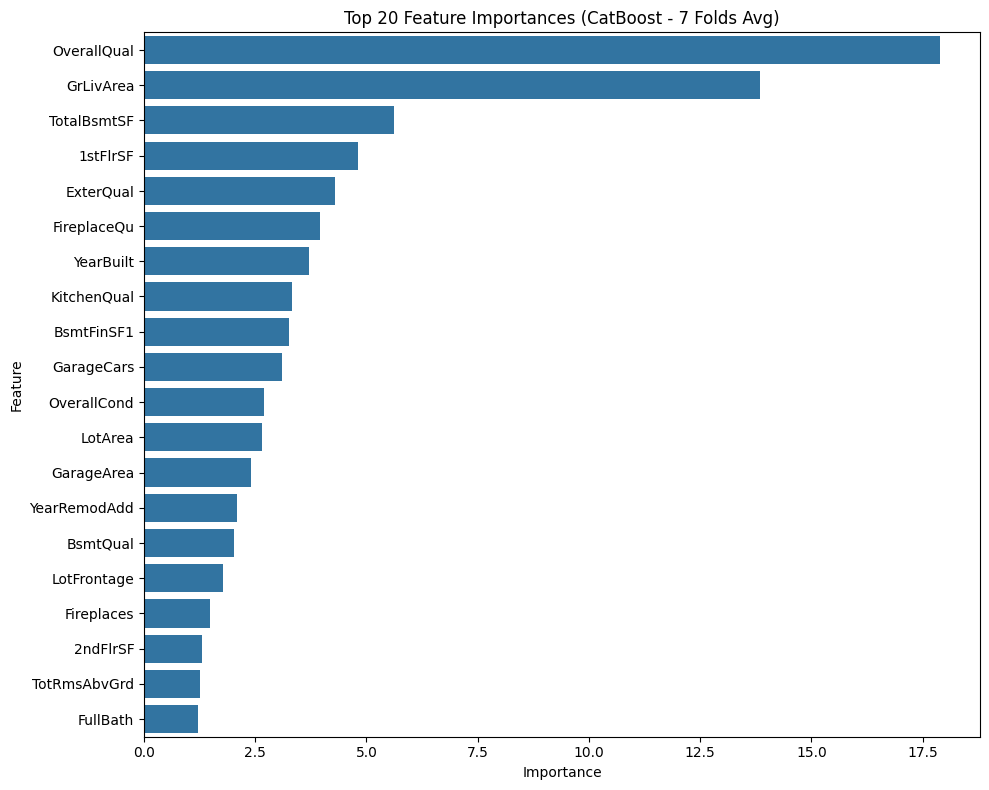

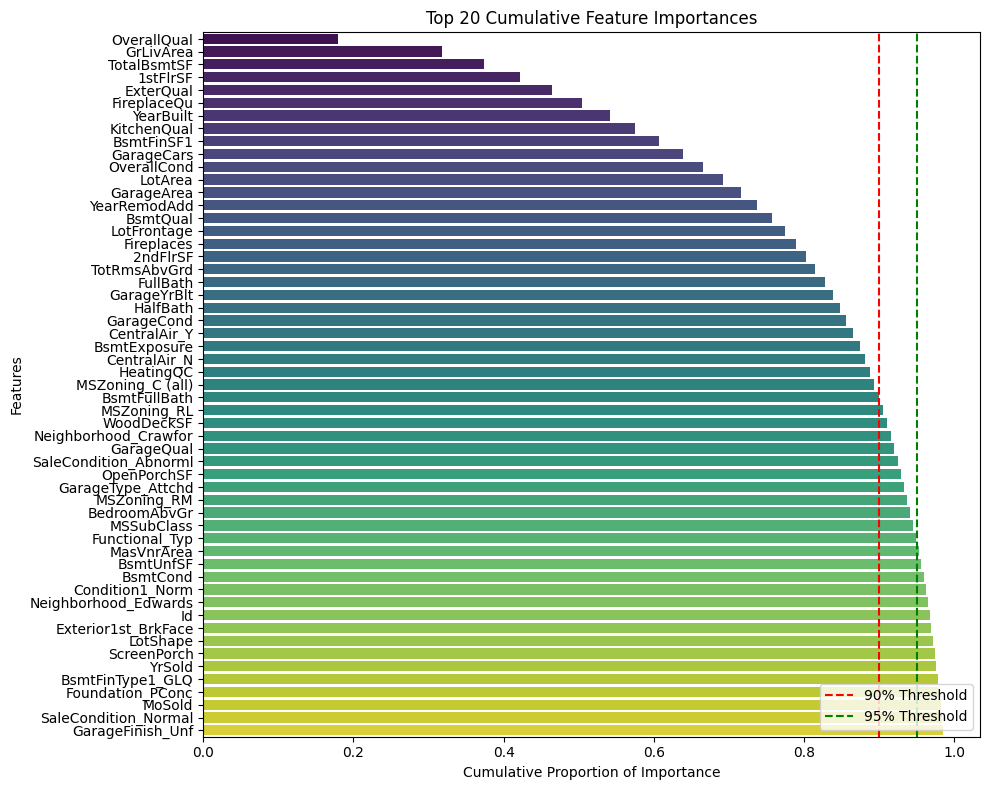

In [95]:
#catboost encoding済みver
# 1. 特徴量(X)と目的変数(y)の準備
drop_cols = ['SalePrice']

X_catboost = train_filtered.drop(columns=drop_cols)
y = y_train_log  # 対数変換済みのターゲット

# --- CatBoost特有の処理：カテゴリ変数列を自動検知 ---
# Xの中でデータ型が 'object'（文字列など）の列名をリスト化してCatBoostに教えます
cat_features = list(X_catboost.select_dtypes(include=['object']).columns)#今回は全てエンコーディングしているので無い

# 7分割のKFold設定
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

train_scores = []
valid_scores = []
feature_importances = np.zeros(X_catboost.shape[1])

print(f"=== CatBoost {n_splits}分割 交差検証を開始 ===")
if len(cat_features) > 0:
    print(f"自動検知したカテゴリ変数 ({len(cat_features)}個): CatBoostに内部処理させます")

# ループで分割・学習・評価を繰り返す
for fold, (train_idx, val_idx) in enumerate(kf.split(X_catboost, y)):
    # データの分割
    X_catboost_train, y_train = X_catboost.iloc[train_idx], y.iloc[train_idx]
    X_catboost_val, y_val = X_catboost.iloc[val_idx], y.iloc[val_idx]
    
    # モデルの構築と学習
    # verbose=0 でLightGBMの時のようなうっとうしいログを完全に消します
    cb = CatBoostRegressor(
        # cat_features=['MSSubClass'],#カテゴリ変数を指定
        iterations=500,       # LightGBMの n_estimators に相当 学習回数
        depth=5,              # max_depth に相当
        learning_rate=0.035,
        random_seed=42,
        verbose=0 ,            # ログを非表示
        l2_leaf_reg=5,
        early_stopping_rounds=50,#50回やって伸びないなら終了
                   
    )
    
    # cat_features を指定して学習
    cb.fit(X_catboost_train, y_train, cat_features=cat_features)
    
    # 予測
    pred_train = cb.predict(X_catboost_train)
    pred_val = cb.predict(X_catboost_val)
    
    # 評価 (RMSE = RMSLE)
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
    
    # スコアの保存
    train_scores.append(rmse_train)
    valid_scores.append(rmse_val)
    
    # 特徴量重要度の加算 (CatBoostは get_feature_importance() を使います)
    feature_importances += cb.get_feature_importance() / n_splits
    
    print(f"Fold {fold+1} | Train: {rmse_train:.5f} | Valid: {rmse_val:.5f} | GAP: {rmse_val - rmse_train:.5f}")

# 全体の平均スコアを計算
mean_train_score = np.mean(train_scores)
mean_valid_score = np.mean(valid_scores)

print("\n=== モデルの総合評価（KFold平均） ===")
print(f"Mean Train Score : {mean_train_score:.5f}")
print(f"Mean Valid Score : {mean_valid_score:.5f}")
print(f"Mean GAP (過学習) : {mean_valid_score - mean_train_score:.5f}")
print("==================================\n")

# 特徴量重要度の表示
importance_df = pd.DataFrame({
    'Feature': X_catboost.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 上位20個をグラフ化
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title(f'Top 20 Feature Importances (CatBoost - {n_splits} Folds Avg)')
plt.tight_layout()
plt.show()




# ==========================================
# 1. まず、累積重要度を計算して列を追加する（超重要！）
# ==========================================
# 重要度が高い順に並び替え
importance_df = importance_df.sort_values('Importance', ascending=False)
# 上から順に足し算（cumsum）して、全体の合計で割ることで 0.0〜1.0 の割合にする
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum()

# ==========================================
# 2. グラフを描画する
# ==========================================
plt.figure(figsize=(10, 8))

# hue='Feature' と legend=False で警告も回避
sns.barplot(
    x='Cumulative_Importance', 
    y='Feature', 
    data=importance_df.head(55), 
    hue='Feature',      
    palette='viridis', 
    legend=False        
)

# 90%と95%の目安ラインを引く
plt.axvline(x=0.90, color='r', linestyle='--', label='90% Threshold')
plt.axvline(x=0.95, color='g', linestyle='--', label='95% Threshold')

# タイトル等は環境に合わせて変えてください
plt.title('Top 20 Cumulative Feature Importances')
plt.xlabel('Cumulative Proportion of Importance')
plt.ylabel('Features')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [99]:
# 1. 累積重要度が95%以下（0.95）の特徴量の名前だけをリスト化して取り出す
threshold = 0.95
features_to_keep = importance_df[importance_df['Cumulative_Importance'] <= threshold]['Feature'].tolist()

print(f"元の特徴量数: {len(importance_df)}")
print(f"残った特徴量数: {len(features_to_keep)}")
print(f"削除された特徴量数: {len(importance_df) - len(features_to_keep)}")

# 2. trainデータとtestデータを、優秀な特徴量だけに絞り込む
# （※目的変数 'SalePrice' がtrainに入っている場合は、それも残すのを忘れずに！）
# ステップ1：まず「選抜メンバー（特徴量）」の名簿をコピーする
features_to_keep_with_target = features_to_keep.copy()

#この時のcumulativeで出したもの自体には目的変数がはいってないためには目的変数が入ってないため

# ステップ2：あった場合（学習データ）、名簿に「SalePrice」を書き足す
#features_to_keep_with_targetの中にはカラムが入ってる
features_to_keep_with_target.append('SalePrice')

train_filtered = train_encoding[features_to_keep_with_target]
test_filtered=test_encoding[features_to_keep]
# test_filtered = test[features_to_keep] # testデータがある場合は同様に絞る

元の特徴量数: 70
残った特徴量数: 40
削除された特徴量数: 30


In [100]:
train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OverallQual            1460 non-null   int64  
 1   GrLivArea              1460 non-null   float64
 2   TotalBsmtSF            1460 non-null   float64
 3   1stFlrSF               1460 non-null   float64
 4   ExterQual              1460 non-null   int64  
 5   FireplaceQu            1460 non-null   int64  
 6   YearBuilt              1460 non-null   int64  
 7   KitchenQual            1460 non-null   int64  
 8   BsmtFinSF1             1460 non-null   int64  
 9   GarageCars             1460 non-null   int64  
 10  OverallCond            1460 non-null   int64  
 11  LotArea                1460 non-null   float64
 12  GarageArea             1460 non-null   int64  
 13  YearRemodAdd           1460 non-null   int64  
 14  BsmtQual               1460 non-null   int64  
 15  LotF

In [ ]:
train_filte.info()

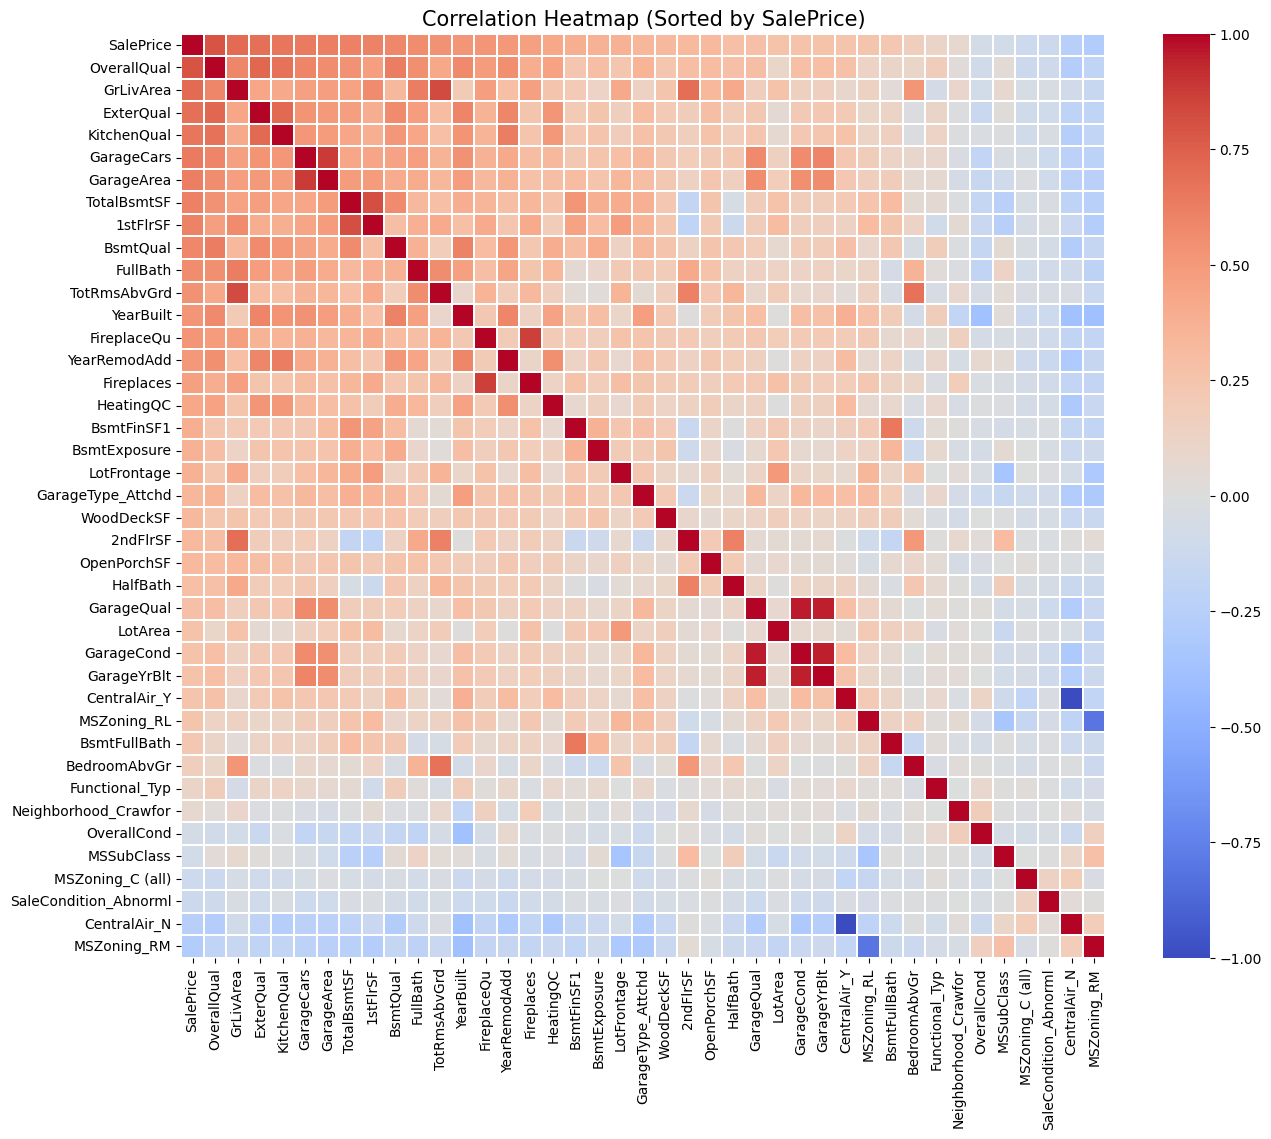

In [98]:
#相関が高いもの同士で割り算、相関が低いもの同士で掛け算がいいらしい

# 1. 相関行列を計算する
# 数値型とブール型（True/False）のみを対象にし、計算のためにfloatに変換します
corr_data = train_filtered.select_dtypes(include=['number', 'bool']).astype(float)
corr_matrix = corr_data.corr()

# 2. SalePriceとの相関係数に基づいて、カラムを並び替える
# これにより、重要な特徴量が左上に集まるので見やすくなります
top_corr_cols = corr_matrix['SalePrice'].sort_values(ascending=False).index
sorted_corr_matrix = train_filtered[top_corr_cols].corr()

# 3. ヒートマップの描画
plt.figure(figsize=(15, 12))  # カラム数が多いので大きめに設定
sns.heatmap(
    sorted_corr_matrix, 
    annot=False,          # 41個だと数字を入れると真っ黒になるのでFalseに
    cmap='coolwarm',      # 正の相関は赤、負の相関は青で表示
    fmt='.2f', 
    linewidths=0.1, 
    square=True
)

plt.title('Correlation Heatmap (Sorted by SalePrice)', fontsize=15)
plt.show()

### 上のヒートマップから以下のことが分かった

FireplaceQuとFireplacesが高い相関<br>
GarageQualとGarageCondが高い相関<br>
GarageQualとGarageYrBlt が高い相関<br>
GarageCondとGarageYrBlが高い相関<br>
CentralAir_YとCentralAir_Nが低い相関<br>
MSZoning_RLとMSZoning_RMが低い相関<br>

↓種類数が多いのでビン分割すると精度さがったので却下

In [ ]:
# # ビン分割したいカラムのリスト（SalePriceは除外しています）
# columns_to_bin = [
#     'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'LotArea', 'BsmtFinSF1',
#     'GarageArea', 'YearBuilt', 'YearRemodAdd', 'LotFrontage', '2ndFlrSF',
#     'GarageYrBlt', 'TotRmsAbvGrd', 'OpenPorchSF', 'WoodDeckSF', 'MasVnrArea',
#     'MSSubClass', 'BsmtUnfSF'
# ]

# for col in columns_to_bin:
#     # 1. trainデータを使って、10等分するための「境界線（bins）」を計算する
#     # duplicates='drop' で「0」ばかりの列でもエラーにならないようにする これにより
#     _, bins = pd.qcut(train_filtered[col], q=10, retbins=True, duplicates='drop')
    
#     # 2. 未知のtestデータが境界線の範囲外（極端な大豪邸など）になってNaNになるのを防ぐため、両端を無限大に拡張
#     bins[0] = -np.inf
#     bins[-1] = np.inf
    
#     # 3. 1〜Nのラベルを作成（duplicates='drop'の影響で10個未満になることもあるため、実際の数に合わせる）
#     num_bins = len(bins) - 1
#     labels = range(1, num_bins + 1)
    
#     # 4. train と test の両方に、全く同じ「境界線」と「ラベル」を適用して上書きする
#     train_filtered[col] = pd.cut(train_filtered[col], bins=bins, labels=labels, include_lowest=True)
    
#     if col in test_filtered.columns:
#         test_filtered[col] = pd.cut(test_filtered[col], bins=bins, labels=labels, include_lowest=True)

# print("ビニング処理が完了しました！")


# #面積と年数、部屋数は明確に大小があるのでビン分割したカテゴリ型の数をint型にする　
# #MSSubClassは明確な大小関係ないのでcatboostにそのまま渡す
# for col in columns_to_bin:
#     if col == 'MSSubClass':
#         # MSSubClassの場合は、CatBoostに「カテゴリ」と認識させるため文字列（str）にする
#         train_filtered[col] = train_filtered[col].astype(str)
#         if col in test_filtered.columns:
#             test_filtered[col] = test_filtered[col].astype(str)
#     else:
#         # それ以外の列（面積や年数など）は、順序を持たせるため整数（int）にする
#         train_filtered[col] = train_filtered[col].astype(int)
#         if col in test_filtered.columns:
#             test_filtered[col] = test_filtered[col].astype(int)

# print("型の変換が完了しました！")

# # 確認のため、各列の型を表示してみる
# # int64（整数）と object（文字列）に分かれていれば大成功です
# print(train_filtered[columns_to_bin].dtypes)

In [ ]:
train_filtered.nunique()

In [ ]:
import xgboost as xgb
print(f"XGBoost version: {xgb.__version__}")

In [ ]:
import xgboost as xgb

# 1. 特徴量(X)と目的変数(y)の準備
# ★ train_filtered（精鋭部隊）を使用します
drop_cols = ['SalePrice']
X_xgb = train_filtered.drop(columns=drop_cols)
y = y_train_log  # 対数変換済みのターゲット

# 7分割のKFold設定
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

train_scores = []
valid_scores = []
# XGBoostの重要度は直接 .feature_importances_ で取得可能です
feature_importances = np.zeros(X_xgb.shape[1])

print(f"=== XGBoost 3.0 {n_splits}分割 交差検証を開始 ===")

# ループで分割・学習・評価を繰り返す
for fold, (train_idx, val_idx) in enumerate(kf.split(X_xgb, y)):
    # データの分割
    X_train, y_train = X_xgb.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X_xgb.iloc[val_idx], y.iloc[val_idx]
    
    # モデルの構築と学習 (XGBoost 3.0 仕様)
    model = xgb.XGBRegressor(
        n_estimators=1000,          # CatBoostのiterationsに相当
        max_depth=5,                # 木の深さ
        learning_rate=0.03,         # 学習率
        
        # --- 強力な過学習対策（ここがポイント） ---
        reg_lambda=15,              # L2正則化（CatBoostのl2_leaf_regに相当）
        reg_alpha=1,                # L1正則化（不要な特徴量をゼロにする力）
        colsample_bytree=0.8,       # 各木を作る際に使う特徴量の割合（ノイズ対策）
        subsample=0.8,              # 各木を作る際に使うデータの割合
        
        random_state=42,
        n_jobs=-1,                  # 全CPUコアを使用
        enable_categorical=False    # すでにエンコーディング済みのためFalseでOK
    )
    
    # 学習 (early_stoppingで無駄な学習をカット)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False # ログ出力を抑制
    )
    
    # 予測
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    
    # 評価 (RMSE)
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
    
    # スコアの保存
    train_scores.append(rmse_train)
    valid_scores.append(rmse_val)
    
    # 特徴量重要度の加算
    feature_importances += model.feature_importances_ / n_splits
    
    print(f"Fold {fold+1} | Train: {rmse_train:.5f} | Valid: {rmse_val:.5f} | GAP: {rmse_val - rmse_train:.5f}")

# 全体の平均スコアを計算
mean_train_score = np.mean(train_scores)
mean_valid_score = np.mean(valid_scores)

print("\n=== XGBoost 3.0 総合評価（KFold平均） ===")
print(f"Mean Train Score : {mean_train_score:.5f}")
print(f"Mean Valid Score : {mean_valid_score:.5f}")
print(f"Mean GAP (過学習) : {mean_valid_score - mean_train_score:.5f}")
print("==================================\n")

# 特徴量重要度の表示
importance_df = pd.DataFrame({
    'Feature': X_xgb.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 上位20個をグラフ化
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), hue='Feature', palette='magma', legend=False)
plt.title(f'Top 20 Feature Importances (XGBoost 3.0)')
plt.tight_layout()
plt.show()

In [ ]:
train_encoding.info()

In [ ]:
#catboost encodingしてないver
# 1. 特徴量(X)と目的変数(y)の準備
drop_cols = ['SalePrice']

X_catboost_encodingnashi = train.drop(columns=drop_cols)
y = y_train_log  # 対数変換済みのターゲット

# --- CatBoost特有の処理：カテゴリ変数列を自動検知 ---
# Xの中でデータ型が 'object'（文字列など）の列名をリスト化してCatBoostに教えます
cat_features = list(X_catboost_encodingnashi.select_dtypes(include=['object']).columns)#今回は全てエンコーディングしているので無い

# 7分割のKFold設定
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

train_scores = []
valid_scores = []
feature_importances = np.zeros(X_catboost_encodingnashi.shape[1])

print(f"=== CatBoost {n_splits}分割 交差検証を開始 ===")
if len(cat_features) > 0:
    print(f"自動検知したカテゴリ変数 ({len(cat_features)}個): CatBoostに内部処理させます")

# ループで分割・学習・評価を繰り返す
for fold, (train_idx, val_idx) in enumerate(kf.split(X_catboost_encodingnashi, y)):
    # データの分割
    X_catboost_encodingnashi_train, y_train = X_catboost_encodingnashi.iloc[train_idx], y.iloc[train_idx]
    X_catboost_encodingnashi_val, y_val = X_catboost_encodingnashi.iloc[val_idx], y.iloc[val_idx]
    
    # モデルの構築と学習
    # verbose=0 でLightGBMの時のようなうっとうしいログを完全に消します
    cb = CatBoostRegressor(
        iterations=500,       # LightGBMの n_estimators に相当
        depth=5,              # max_depth に相当
        learning_rate=0.035,
        random_seed=42,
        verbose=0             # ログを非表示
    )
    
    # cat_features を指定して学習
    cb.fit(X_catboost_encodingnashi_train, y_train, cat_features=cat_features)
    
    # 予測
    pred_train = cb.predict(X_catboost_encodingnashi_train)
    pred_val = cb.predict(X_catboost_encodingnashi_val)
    
    # 評価 (RMSE = RMSLE)
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
    
    # スコアの保存
    train_scores.append(rmse_train)
    valid_scores.append(rmse_val)
    
    # 特徴量重要度の加算 (CatBoostは get_feature_importance() を使います)
    feature_importances += cb.get_feature_importance() / n_splits
    
    print(f"Fold {fold+1} | Train: {rmse_train:.5f} | Valid: {rmse_val:.5f} | GAP: {rmse_val - rmse_train:.5f}")

# 全体の平均スコアを計算
mean_train_score = np.mean(train_scores)
mean_valid_score = np.mean(valid_scores)

print("\n=== モデルの総合評価（KFold平均） ===")
print(f"Mean Train Score : {mean_train_score:.5f}")
print(f"Mean Valid Score : {mean_valid_score:.5f}")
print(f"Mean GAP (過学習) : {mean_valid_score - mean_train_score:.5f}")
print("==================================\n")

# 特徴量重要度の表示
importance_df = pd.DataFrame({
    'Feature': X_catboost_encodingnashi.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 上位20個をグラフ化
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title(f'Top 20 Feature Importances (CatBoost - {n_splits} Folds Avg)')
plt.tight_layout()
plt.show()

# 6,提出
提出のための処理を行う

In [ ]:
# 元のCSVファイルから 'Id' 列だけをピンポイントで読み直す
test_id = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')['Id']

print("IDの復元に成功しました！ 数:", len(test_id))

In [ ]:
#2. 【最重要】学習に使った列「だけ」を test_encoding から抽出する
# これにより、余計な列は自動的に無視され、列の並び順も X と完全に一致します
test_X = test_filtered[X_catboost.columns]

# 3. 予測（対数 log1p の状態）
final_model = CatBoostRegressor(
    iterations=500,       
    depth=5,              
    learning_rate=0.035,
    random_seed=42,
    verbose=0             
)
final_model.fit(X_catboost, y) # KFoldの分割ではなく、Xとyを丸ごと渡す！

log_preds = final_model.predict(test_X)

# 4. 対数から元の価格に戻す
actual_preds = np.expm1(log_preds)

# 5. 提出用ファイル作成
submission = pd.DataFrame({
    'Id': test_id,
    'SalePrice': actual_preds
})

submission.to_csv('submission.csv', index=False)
print("submission.csv の作成に成功しました！")